# Automated Analysis Pipeline for Steinmetz Dataset

This notebook demonstrates how to use the automated pipeline for batch processing, including:
1. Processing multiple sessions automatically
2. Generating standardized visualizations
3. Exporting results in a structured format
4. Creating summary reports

In [8]:
import sys
sys.path.append('../src')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pipeline import AnalysisPipeline

# Set plotting style
#plt.style.use('seaborn')
sns.set_context("talk")

## 1. Initialize Pipeline

In [9]:
# Create output directory with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = f'../results/batch_analysis_{timestamp}'

# Initialize pipeline
pipeline = AnalysisPipeline(output_dir=output_dir)

# Define sessions to analyze
session_indices = [11, 12, 13]  # Example sessions
print(f"Will analyze sessions: {session_indices}")

Will analyze sessions: [11, 12, 13]


## 2. Single Session Analysis Example

Error processing session 11: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Analyses completed for session 11:


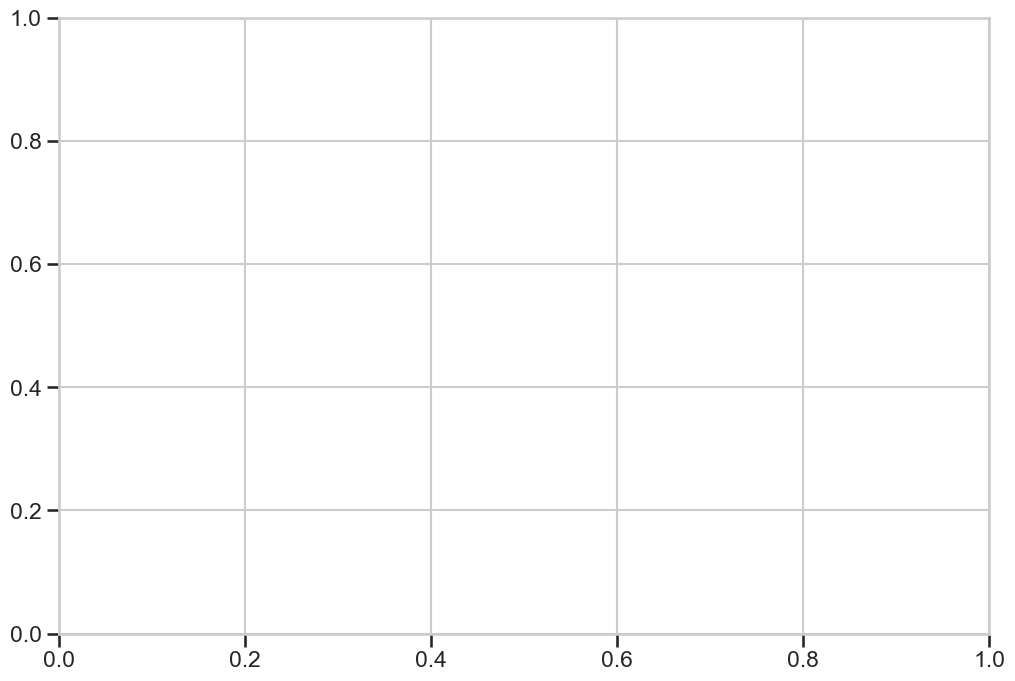

In [10]:
# Process a single session with all analyses
session_results = pipeline.process_session(
    session_idx=11,
    analyses=['basic', 'lfp', 'population', 'behavior', 'cross_regional']
)

print("\nAnalyses completed for session 11:")
for analysis_type, results in session_results.items():
    if isinstance(results, dict):
        print(f"\n{analysis_type}:")
        for key in results.keys():
            print(f"  - {key}")

## 3. Batch Processing

In [11]:
# Process multiple sessions in parallel
batch_results = pipeline.batch_process(
    session_indices=session_indices,
    analyses=['basic', 'lfp', 'population'],  # Subset of analyses for example
    n_workers=3
)

print("\nBatch processing completed.")
print("Results available for sessions:", list(batch_results.keys()))

Error processing session 11: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error processing session 13: name 'plt' is not defined
Error processing session 12: name 'plt' is not defined

Batch processing completed.
Results available for sessions: [11, 12, 13]


## 4. Results Summary and Visualization

/var/folders/hy/bsqf9k_s08zb3n3clr6yktm00000gn/T/ipykernel_7543/329823835.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


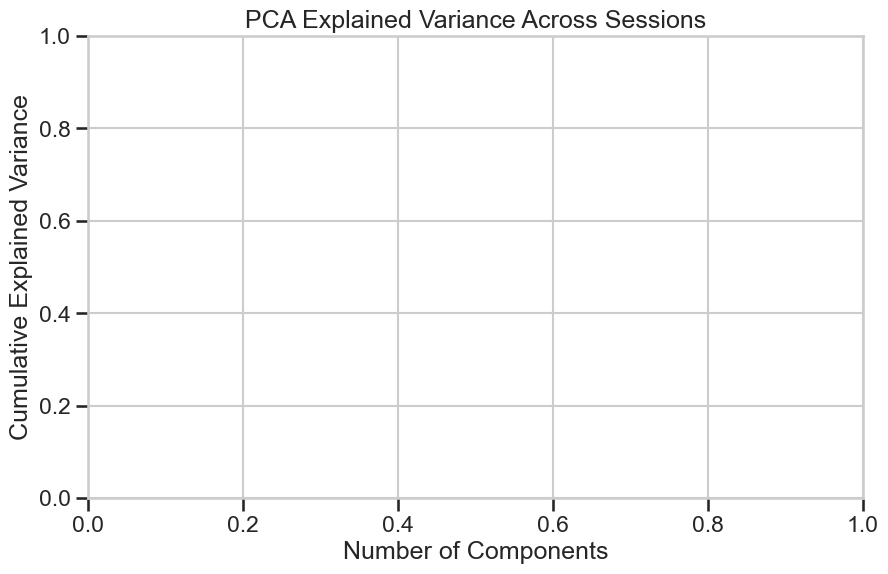

In [12]:
def create_summary_plots(batch_results):
    """Create summary plots across all sessions."""
    # Example: Compare PCA explained variance across sessions
    plt.figure(figsize=(10, 6))
    for session_idx, results in batch_results.items():
        if 'population' in results:
            if 'explained_variance' in results['population']:
                explained_var = results['population']['explained_variance']
                plt.plot(np.cumsum(explained_var), 
                        label=f'Session {session_idx}')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance Across Sessions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create summary plots
create_summary_plots(batch_results)

## 5. Export Results

In [13]:
def export_summary_report(batch_results, output_dir):
    """Create and export a summary report of the analyses."""
    summary = {
        'timestamp': datetime.now().isoformat(),
        'n_sessions': len(batch_results),
        'session_summaries': {}
    }
    
    for session_idx, results in batch_results.items():
        session_summary = {
            'analyses_completed': list(results.keys()),
            'error': results.get('error', None)
        }
        
        # Add analysis-specific metrics
        if 'population' in results:
            n_components_80 = np.where(
                np.cumsum(results['population']['explained_variance']) >= 0.8
            )[0][0] + 1
            session_summary['n_components_80_var'] = int(n_components_80)
        
        summary['session_summaries'][str(session_idx)] = session_summary
    
    # Save summary report
    report_path = os.path.join(output_dir, 'analysis_summary.json')
    with open(report_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    return summary

# Export summary report
summary = export_summary_report(batch_results, output_dir)
print("\nAnalysis Summary:")
print(json.dumps(summary, indent=2))


Analysis Summary:
{
  "timestamp": "2025-03-04T13:45:35.874820",
  "n_sessions": 3,
  "session_summaries": {
    "11": {
      "analyses_completed": [
        "error"
      ],
      "error": "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
    },
    "12": {
      "analyses_completed": [
        "error"
      ],
      "error": "name 'plt' is not defined"
    },
    "13": {
      "analyses_completed": [
        "error"
      ],
      "error": "name 'plt' is not defined"
    }
  }
}


## 6. Advanced Pipeline Configuration

In [14]:
# Example: Custom analysis configuration
custom_config = {
    'basic': {
        'time_window': (-0.5, 1.0),
        'bin_size': 0.01
    },
    'lfp': {
        'freq_bands': {
            'theta': (4, 8),
            'beta': (13, 30),
            'gamma': (30, 80)
        }
    },
    'population': {
        'n_components': 10,
        'scale_data': True
    }
}

# Process a session with custom configuration
custom_results = pipeline.process_session(
    session_idx=11,
    analyses=['basic', 'lfp', 'population'],
    config=custom_config
)

print("\nCustom analysis completed with configuration:")
print(json.dumps(custom_config, indent=2))

TypeError: AnalysisPipeline.process_session() got an unexpected keyword argument 'config'

## 7. Performance Monitoring

In [8]:
def monitor_analysis_performance(batch_results):
    """Monitor and report analysis performance metrics."""
    performance_metrics = {
        'total_sessions': len(batch_results),
        'successful_sessions': sum(1 for r in batch_results.values() if 'error' not in r),
        'failed_sessions': sum(1 for r in batch_results.values() if 'error' in r),
        'analyses_completed': {}
    }
    
    # Count completed analyses
    for results in batch_results.values():
        for analysis in results.keys():
            if analysis != 'error':
                performance_metrics['analyses_completed'][analysis] = \
                    performance_metrics['analyses_completed'].get(analysis, 0) + 1
    
    print("\nPerformance Metrics:")
    print(f"Total sessions processed: {performance_metrics['total_sessions']}")
    print(f"Successful sessions: {performance_metrics['successful_sessions']}")
    print(f"Failed sessions: {performance_metrics['failed_sessions']}")
    print("\nAnalyses completed:")
    for analysis, count in performance_metrics['analyses_completed'].items():
        print(f"  {analysis}: {count} sessions")

# Monitor performance
monitor_analysis_performance(batch_results)

NameError: name 'batch_results' is not defined